In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


In [2]:
fg_path = 'fear_greed_index.csv'
hist_path = 'historical_data (1).csv'

In [3]:
fg = pd.read_csv(fg_path, low_memory=False)
hist = pd.read_csv(hist_path, low_memory=False)

In [4]:
fg.columns = [c.strip().lower().replace(' ', '_') for c in fg.columns]
hist.columns = [c.strip().lower().replace(' ', '_') for c in hist.columns]


In [5]:
date_col_fg = None
for c in ['date', 'timestamp', 'time']:
    if c in fg.columns:
        date_col_fg = c
        break
if date_col_fg is None:
    date_col_fg = fg.columns[0]
fg[date_col_fg] = pd.to_datetime(fg[date_col_fg], errors='coerce')
fg = fg.rename(columns={date_col_fg: 'date'})
fg['date'] = pd.to_datetime(fg['date']).dt.normalize()

In [6]:
time_col = None
for c in ['timestamp_ist','timestamp','time','date','datetime']:
    if c in hist.columns:
        time_col = c
        break
if time_col is None:
    raise ValueError("No time-like column found in historical data.")
hist[time_col] = pd.to_datetime(hist[time_col], errors='coerce')
hist = hist.dropna(subset=[time_col])
hist = hist.rename(columns={time_col: 'time'})
hist['date'] = hist['time'].dt.normalize()

In [7]:
if 'closed_pnl' in hist.columns:
    hist['closed_pnl'] = pd.to_numeric(hist['closed_pnl'], errors='coerce')
else:
    # try alternative spelled column
    for c in hist.columns:
        if 'pnl' in c.lower() or 'closed' in c.lower():
            hist = hist.rename(columns={c: 'closed_pnl'})
            hist['closed_pnl'] = pd.to_numeric(hist['closed_pnl'], errors='coerce')
            break


In [8]:
if 'size_usd' in hist.columns:
    hist['size_usd'] = pd.to_numeric(hist['size_usd'], errors='coerce')
if 'size_tokens' in hist.columns:
    hist['size_tokens'] = pd.to_numeric(hist['size_tokens'], errors='coerce')

In [9]:
if 'value' in fg.columns:
    fg['value'] = pd.to_numeric(fg['value'], errors='coerce')
    fg['sentiment_score_norm'] = fg['value'] / 100.0
else:
    mapping = {'extreme fear':0,'fear':1,'neutral':2,'greed':3,'extreme greed':4}
    if 'classification' in fg.columns:
        fg['sentiment_score_norm'] = fg['classification'].str.lower().map(mapping)
    else:
        fg['sentiment_score_norm'] = np.nan


In [10]:
def win_rate(series):
    s = series.dropna()
    if len(s)==0:
        return np.nan
    return (s > 0).sum() / len(s)

daily = hist.groupby('date').agg(
    num_trades=('account','count'),
    total_closedpnl=('closed_pnl','sum'),
    mean_closedpnl=('closed_pnl','mean'),
    median_closedpnl=('closed_pnl','median'),
    win_rate=('closed_pnl', win_rate),
    avg_size_usd=('size_usd','mean'),
    avg_size_tokens=('size_tokens','mean')
).reset_index()

In [11]:
merged = pd.merge(daily, fg[['date','classification','sentiment_score_norm']], on='date', how='left')

In [12]:
merged_sorted = merged.sort_values('date').copy()
merged_sorted['pnl_7d'] = merged_sorted['total_closedpnl'].rolling(7, min_periods=1).mean()
merged_sorted['sent_7d'] = merged_sorted['sentiment_score_norm'].rolling(7, min_periods=1).mean()


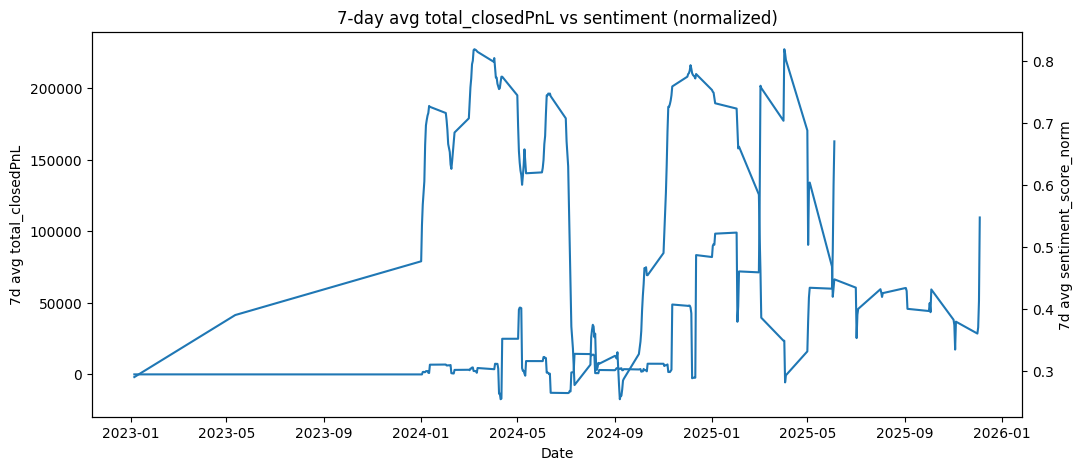

In [13]:
plt.figure(figsize=(12,5))
plt.plot(merged_sorted['date'], merged_sorted['pnl_7d'], label='7d avg total_closedPnL')
plt.xlabel('Date'); plt.ylabel('7d avg total_closedPnL')
plt.twinx()
plt.plot(merged_sorted['date'], merged_sorted['sent_7d'], label='7d avg sentiment (norm)')
plt.ylabel('7d avg sentiment_score_norm')
plt.title('7-day avg total_closedPnL vs sentiment (normalized)')
plt.show()


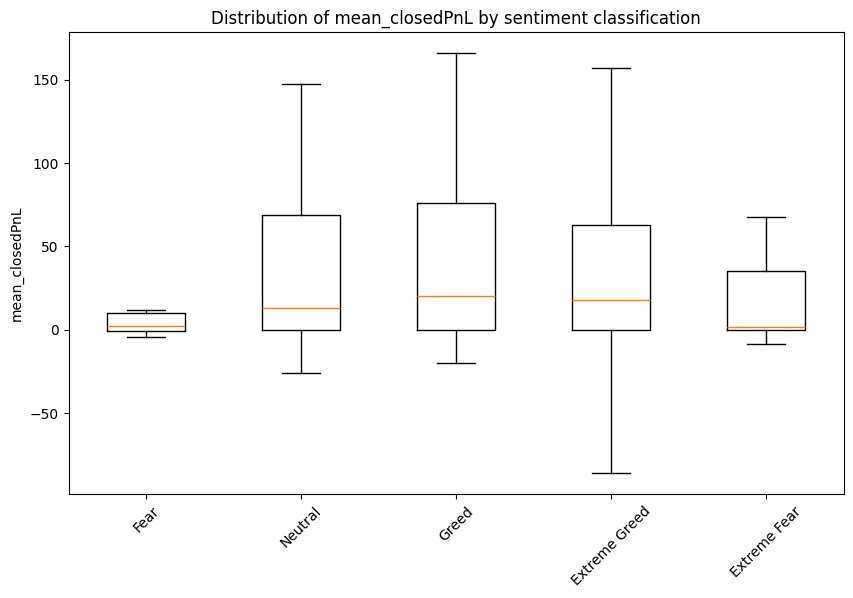

In [14]:
groups = [g['mean_closedpnl'].dropna().values for _, g in merged.groupby('classification')]
labels = list(merged['classification'].dropna().unique())
if len(groups) > 0:
    plt.figure(figsize=(10,6))
    plt.boxplot(groups, labels=labels, showfliers=False)
    plt.xticks(rotation=45)
    plt.ylabel('mean_closedPnL')
    plt.title('Distribution of mean_closedPnL by sentiment classification')
    plt.show()

In [15]:
anova_result = None
kruskal_result = None
if len(groups) >= 2:
    try:
        anova_result = stats.f_oneway(*groups)
    except Exception as e:
        anova_result = ("ANOVA error", str(e))
    try:
        kruskal_result = stats.kruskal(*groups)
    except Exception as e:
        kruskal_result = ("Kruskal error", str(e))

print("ANOVA result:", anova_result)
print("Kruskal-Wallis result:", kruskal_result)

ANOVA result: F_onewayResult(statistic=np.float64(0.34695556822892387), pvalue=np.float64(0.8458341460033985))
Kruskal-Wallis result: KruskalResult(statistic=np.float64(3.770634505168936), pvalue=np.float64(0.4379360462316225))


In [16]:
corrs = {}
for col in ['total_closedpnl','mean_closedpnl','win_rate','avg_size_usd','avg_size_tokens']:
    if col in merged.columns and 'sentiment_score_norm' in merged.columns:
        valid = merged[[col,'sentiment_score_norm']].dropna()
        if len(valid) > 2:
            rho, p = stats.spearmanr(valid['sentiment_score_norm'], valid[col])
            corrs[col] = (float(rho), float(p))
        else:
            corrs[col] = (np.nan, np.nan)
print("Spearman correlations:", corrs)

Spearman correlations: {'total_closedpnl': (-0.020750955713910058, 0.7957955646120582), 'mean_closedpnl': (0.049428248698236685, 0.5374014547128709), 'win_rate': (0.001165760188955586, 0.9884015367100518), 'avg_size_usd': (0.169558754119592, 0.03318449462939386), 'avg_size_tokens': (0.054004615394230196, 0.500356195533397)}


In [17]:
symbol_col = 'coin' if 'coin' in hist.columns else ('symbol' if 'symbol' in hist.columns else None)
account_agg = hist.groupby('account').agg(
    trades_count=('account','count'),
    total_closedpnl=('closed_pnl','sum'),
    mean_closedpnl=('closed_pnl','mean'),
    win_rate=('closed_pnl', win_rate),
    avg_size_usd=('size_usd','mean'),
    avg_size_tokens=('size_tokens','mean')
).reset_index()

In [18]:
if symbol_col:
    uniq = hist.groupby('account')[symbol_col].nunique().reset_index().rename(columns={symbol_col:'unique_symbols'})
    account_agg = account_agg.merge(uniq, on='account', how='left')
else:
    account_agg['unique_symbols'] = np.nan

account_agg['perf_score'] = account_agg['mean_closedpnl'] * np.sqrt(account_agg['trades_count'].replace(0, np.nan))


In [19]:
cluster_feats = ['trades_count','win_rate','mean_closedpnl','avg_size_usd']
cluster_df = account_agg[cluster_feats].fillna(0)
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_df)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
account_agg['cluster'] = kmeans.fit_predict(cluster_scaled)

In [20]:
merged.to_csv('aggregated_daily_merged.csv', index=False)
account_agg.to_csv('account_aggregates_with_clusters.csv', index=False)
account_agg.to_csv('account_aggregates.csv', index=False)

print("Saved files: aggregated_daily_merged.csv, account_aggregates.csv, account_aggregates_with_clusters.csv")


Saved files: aggregated_daily_merged.csv, account_aggregates.csv, account_aggregates_with_clusters.csv
